In [1]:
import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./data/BTC-M.csv',parse_dates=[0], index_col=[0])
df.drop('value',axis=1, inplace=True)
df.head(3)

,open,high,low,close,volume
2018-09-19 23:50:00,7180000.0,7187000.0,7180000.0,7187000.0,0.504830
2018-09-19 23:51:00,7186000.0,7188000.0,7181000.0,7181000.0,0.882076
2018-09-19 23:52:00,7184000.0,7188000.0,7183000.0,7188000.0,0.486359


In [3]:
from pymodule.dllMod import pred_per
pred = pred_per(df, 0.015)

In [4]:
y = np.array(pred, dtype=np.float32)
y = np.reciprocal(y)*4 - 0.02
y[y == np.inf] = 0
y = y / abs(y).max()
y = np.tanh(y)

array([[-246],
       [-245],
       [-244],
       ...,
       [   0],
       [   0],
       [   0]])

In [5]:
from pymodule.dataMod import OHLCDataset

seq_length = 20
dataset = OHLCDataset(df[10:-4], y[10:-4], seq_length)

In [6]:
from torch.utils.data import DataLoader, random_split

test_size = 262144
train_set, test_set = random_split(dataset, [len(dataset) - test_size, test_size])
print(f'train dataset length : {len(train_set)}')
print(f'test dataset length : {len(test_set)}')

train_dloader = DataLoader(train_set, batch_size=512, shuffle=True, drop_last=True)
test_dloader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=True)

train dataset length : 1595574
test dataset length : 262144


In [7]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

class OLNNm(nn.Module):
    def __init__(self, seq_length):
        super(OLNNm, self).__init__()
        self.conv1_1 = nn.Conv1d(in_channels=5, out_channels=8, kernel_size=2)
        self.conv1_2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=4)
        self.conv1_3 = nn.Conv1d(in_channels=8, out_channels=5, kernel_size=4)
        self.conv1_4 = nn.Conv1d(in_channels=5, out_channels=3, kernel_size=2)
        self.act1 = nn.GELU()
        
        self.conv2_1 = nn.Conv1d(in_channels=5, out_channels=8, kernel_size=2)
        self.conv2_2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=4)
        self.conv2_3 = nn.Conv1d(in_channels=8, out_channels=5, kernel_size=4)
        self.conv2_4 = nn.Conv1d(in_channels=5, out_channels=3, kernel_size=2)
        self.act2 = nn.GELU()
        
        self.conv3_1 = nn.Conv1d(in_channels=5, out_channels=8, kernel_size=2)
        self.conv3_2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=4)
        self.conv3_3 = nn.Conv1d(in_channels=8, out_channels=5, kernel_size=4)
        self.conv3_4 = nn.Conv1d(in_channels=5, out_channels=3, kernel_size=2)
        self.act3 = nn.GELU()
        
        self.conv4_1 = nn.Conv1d(in_channels=5, out_channels=8, kernel_size=2)
        self.conv4_2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=4)
        self.conv4_3 = nn.Conv1d(in_channels=8, out_channels=5, kernel_size=4)
        self.conv4_4 = nn.Conv1d(in_channels=5, out_channels=3, kernel_size=2)
        self.act4 = nn.GELU()
        
        self.lstm1 = nn.LSTM(input_size = 12, hidden_size = 6, num_layers = 4, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(input_size = 12, hidden_size = 6, num_layers = 4, batch_first=True, dropout=0.3)
        self.conv5 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=4)
        self.conv6 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=4)
        self.conv7 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=4)
        
        self.fc1 = nn.Linear(27,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,8)
        self.fc4 = nn.Linear(8,1)
        
    def forward(self, x):
        x1 = self.conv1_1(x[:,0])
        x1 = self.conv1_2(x1)
        x1 = self.conv1_3(x1)
        x1 = self.act1(self.conv1_4(x1))
        
        x2 = self.conv2_1(x[:,1])
        x2 = self.conv2_2(x2)
        x2 = self.conv2_3(x2)
        x2 = self.act2(self.conv2_4(x2))
        
        x3 = self.conv3_1(x[:,2])
        x3 = self.conv3_2(x3)
        x3 = self.conv3_3(x3)
        x3 = self.act3(self.conv3_4(x3))
        
        x4 = self.conv4_1(x[:,3])
        x4 = self.conv4_2(x4)
        x4 = self.conv4_3(x4)
        x4 = self.act4(self.conv4_4(x4))
        
        x = torch.cat((x1,x2,x3,x4),1)
        
        x1, (h1,c1) = self.lstm1(x)
        x2 = torch.permute(x,(0,2,1))
        x2, (h2,c2) = self.lstm2(x2)
    
        x = torch.cat((x1,x2),2)
        x = torch.unsqueeze(x,1)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        
        x = self.fc1(x.flatten(1))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

model = OLNNm(seq_length).to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [16]:
import pickle

losses =[]
val_losses=[]
path = "./OLLNNm.pt"
# with open("ollm_train.pkl", "rb") as fp:
#     losses = pickle.load(fp)
# with open("ollm_test.pkl", "rb") as fp:
#     val_losses = pickle.load(fp)
model = torch.load(path).to(device)

In [17]:
from pymodule.models import fit

start = time.time()
for epoch in range(30):
    epoch_loss = fit(epoch,model,train_dloader, criterion, optimizer, phase = 'train')
    losses.append(epoch_loss)
    val_epoch_loss = fit(epoch, model, test_dloader, criterion, optimizer, phase ='valid')
    val_losses.append(val_epoch_loss)
    print("{:0,.2f}분".format((time.time()-start)/60))
torch.save(model, path)

epoch:0, trainloss is -0.03145385498102428
epoch:0, validloss is -0.02433547424027438
2.54분
epoch:1, trainloss is -0.03145401170539224
epoch:1, validloss is -0.024335474193662776
5.05분
epoch:2, trainloss is -0.03145354180782797
epoch:2, validloss is -0.024335474205599894
7.49분
epoch:3, trainloss is -0.031454286641339306
epoch:3, validloss is -0.024335474163535764
9.94분
epoch:4, trainloss is -0.03145599694865834
epoch:4, validloss is -0.024335474205145147
12.36분
epoch:5, trainloss is -0.0314532737741186
epoch:5, validloss is -0.024335474162398896
14.80분
epoch:6, trainloss is -0.031453919944421635
epoch:6, validloss is -0.024335474206395702
17.22분
epoch:7, trainloss is -0.03145488303908514
epoch:7, validloss is -0.024335474224585596
19.75분
epoch:8, trainloss is -0.03145543145259167
epoch:8, validloss is -0.024335474206282015
22.37분
epoch:9, trainloss is -0.03145410601286299
epoch:9, validloss is -0.024335474204235652
24.97분
epoch:10, trainloss is -0.03145551179988623
epoch:10, validloss 

KeyboardInterrupt: 

In [18]:
torch.save(model, path)

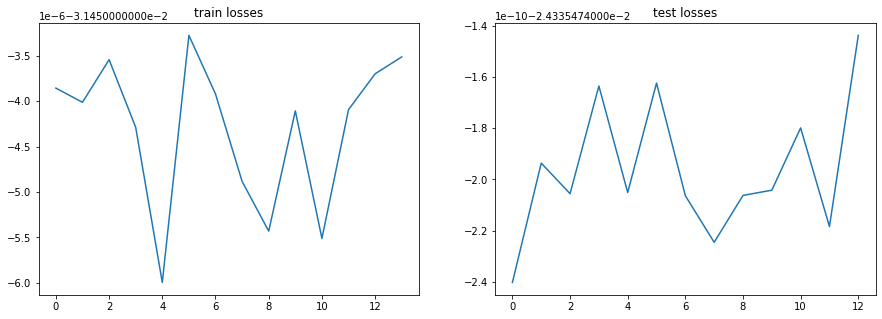

In [19]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(losses)
ax[0].set_title('train losses')

ax[1].plot(val_losses)
ax[1].set_title('test losses')
plt.show()

In [ ]:
with open("ollm_train.pkl", "wb") as fp:
    pickle.dump(losses,fp)
with open("ollm_test.pkl", "wb") as fp:
    pickle.dump(val_losses, fp)

In [ ]:
import torch.onnx
model.eval()
dummy_input = torch.randn(1,4,5,seq_length).to(device)
torch_out = model(dummy_input)

torch.onnx.export(model, dummy_input, "OLLNNm.onnx", export_params=True,
                 do_constant_folding=True, input_names=['input'], output_names=['output'],
                 opset_version=9)